# Лабораторная работа №3: Решающее дерево (Decision Tree)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, mean_absolute_error, mean_squared_error,
                             r2_score, mean_absolute_percentage_error, confusion_matrix, roc_curve)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Создание базового решения (Бейзлайн)

### 2.1 Загрузка и подготовка данных

In [2]:
df_clf = pd.read_csv('data/fake_job_postings.csv')

def count_words(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

def count_chars(text):
    if pd.isna(text):
        return 0
    return len(str(text))

# Создаём копию и добавляем новые признаки
df_clf_prep = df_clf.copy()
text_columns = ['title', 'description', 'requirements']
for col in text_columns:
    if col in df_clf_prep.columns:
        df_clf_prep[f'{col}_word_count'] = df_clf_prep[col].apply(count_words)
        df_clf_prep[f'{col}_char_count'] = df_clf_prep[col].apply(count_chars)

# Выбираем числовые признаки
numeric_features = df_clf_prep.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'job_id' in numeric_features:
    numeric_features.remove('job_id')
if 'fraudulent' in numeric_features:
    numeric_features.remove('fraudulent')

# Формируем матрицу признаков и целевую переменную
X_clf = df_clf_prep[numeric_features]
y_clf = df_clf_prep['fraudulent']
X_clf = X_clf.fillna(X_clf.mean())

# Загружаем датасет auto-mpg для регрессии
df_reg = pd.read_csv('data/auto-mpg.csv')
df_reg_prep = df_reg.copy()
df_reg_prep = df_reg_prep.drop(['car name'], axis=1)
df_reg_prep['horsepower'] = pd.to_numeric(df_reg_prep['horsepower'], errors='coerce')
df_reg_prep = df_reg_prep.dropna()

X_reg = df_reg_prep.drop('mpg', axis=1)
y_reg = df_reg_prep['mpg']

# Разделяем данные (80/20 с стратификацией для классификации)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Разделяем данные для регрессии
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Классификация: X_train={X_clf_train.shape}, X_test={X_clf_test.shape}")
print(f"Регрессия:     X_train={X_reg_train.shape}, X_test={X_reg_test.shape}")

Классификация: X_train=(14304, 9), X_test=(3576, 9)
Регрессия:     X_train=(313, 7), X_test=(79, 7)


### 2.2 Базовое решающее дерево для классификации

In [3]:
# Создаём и обучаем базовое решающее дерево БЕЗ ограничений
# random_state=42 обеспечивает воспроизводимость результатов
dt_baseline_clf = DecisionTreeClassifier(random_state=42)
dt_baseline_clf.fit(X_clf_train, y_clf_train)

# Делаем предсказания на тестовой выборке
y_clf_pred_baseline = dt_baseline_clf.predict(X_clf_test)
# Получаем вероятности для ROC-AUC
y_clf_proba_baseline = dt_baseline_clf.predict_proba(X_clf_test)[:, 1]

# Вычисляем метрики качества классификации
acc_baseline_clf = accuracy_score(y_clf_test, y_clf_pred_baseline)
prec_baseline_clf = precision_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
rec_baseline_clf = recall_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
f1_baseline_clf = f1_score(y_clf_test, y_clf_pred_baseline, zero_division=0)
auc_baseline_clf = roc_auc_score(y_clf_test, y_clf_proba_baseline)

print("КЛАССИФИКАЦИЯ - БАЗОВОЕ РЕШАЮЩЕЕ ДЕРЕВО (без ограничений)")
print(f"Accuracy:  {acc_baseline_clf:.4f}")
print(f"Precision: {prec_baseline_clf:.4f}")
print(f"Recall:    {rec_baseline_clf:.4f}")
print(f"F1-score:  {f1_baseline_clf:.4f}")
print(f"ROC-AUC:   {auc_baseline_clf:.4f}")
print(f"Глубина дерева: {dt_baseline_clf.get_depth()}")
print(f"Количество листьев: {dt_baseline_clf.get_n_leaves()}")

КЛАССИФИКАЦИЯ - БАЗОВОЕ РЕШАЮЩЕЕ ДЕРЕВО (без ограничений)
Accuracy:  0.9499
Precision: 0.4831
Recall:    0.4971
F1-score:  0.4900
ROC-AUC:   0.7350
Глубина дерева: 24
Количество листьев: 745


### 2.3 Базовое решающее дерево для регрессии

In [4]:
# Создаём и обучаем базовое решающее дерево для регрессии БЕЗ ограничений
dt_baseline_reg = DecisionTreeRegressor(random_state=42)
dt_baseline_reg.fit(X_reg_train, y_reg_train)

# Делаем предсказания на тестовой выборке
y_reg_pred_baseline = dt_baseline_reg.predict(X_reg_test)

# Вычисляем метрики качества регрессии
mae_baseline_reg = mean_absolute_error(y_reg_test, y_reg_pred_baseline)
rmse_baseline_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_baseline))
r2_baseline_reg = r2_score(y_reg_test, y_reg_pred_baseline)
mape_baseline_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_baseline)

print("\nРЕГРЕССИЯ - БАЗОВОЕ РЕШАЮЩЕЕ ДЕРЕВО (без ограничений)")
print(f"MAE:  {mae_baseline_reg:.4f}")
print(f"RMSE: {rmse_baseline_reg:.4f}")
print(f"R²:   {r2_baseline_reg:.4f}")
print(f"MAPE: {mape_baseline_reg:.4f}%")
print(f"Глубина дерева: {dt_baseline_reg.get_depth()}")
print(f"Количество листьев: {dt_baseline_reg.get_n_leaves()}")


РЕГРЕССИЯ - БАЗОВОЕ РЕШАЮЩЕЕ ДЕРЕВО (без ограничений)
MAE:  2.2595
RMSE: 3.3806
R²:   0.7761
MAPE: 0.0993%
Глубина дерева: 16
Количество листьев: 262


## 3. Улучшение моделей через оптимизацию

### 3.1 Оптимизация для классификации (контроль сложности дерева)

In [5]:
# GridSearchCV для подбора оптимальных гиперпараметров дерева
# max_depth - максимальная глубина дерева (снижает переобучение)
# min_samples_split - минимальное количество образцов для разбиения узла
# min_samples_leaf - минимальное количество образцов в листе (регуляризация)

param_grid_clf = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV с кросс-валидацией для надежной оценки
grid_search_clf = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_clf,
    cv=5,  # 5-fold кросс-валидация
    scoring='f1',  # оптимизируем по F1-score (важно для дисбаланса)
    n_jobs=-1  # используем все процессоры
)

# Обучаем GridSearchCV на исходных (немасштабированных) данных
# Деревья не требуют масштабирования
grid_search_clf.fit(X_clf_train, y_clf_train)

# Получаем лучшую модель и её параметры
dt_improved_clf = grid_search_clf.best_estimator_
best_params_clf = grid_search_clf.best_params_

print(f"Лучшие параметры:")
print(f"  max_depth: {best_params_clf['max_depth']}")
print(f"  min_samples_split: {best_params_clf['min_samples_split']}")
print(f"  min_samples_leaf: {best_params_clf['min_samples_leaf']}")
print(f"Лучший F1-score (кросс-валидация): {grid_search_clf.best_score_:.4f}")

# Делаем предсказания оптимизированной моделью
y_clf_pred_improved = dt_improved_clf.predict(X_clf_test)
y_clf_proba_improved = dt_improved_clf.predict_proba(X_clf_test)[:, 1]

# Вычисляем метрики для оптимизированной модели
acc_improved_clf = accuracy_score(y_clf_test, y_clf_pred_improved)
prec_improved_clf = precision_score(y_clf_test, y_clf_pred_improved, zero_division=0)
rec_improved_clf = recall_score(y_clf_test, y_clf_pred_improved, zero_division=0)
f1_improved_clf = f1_score(y_clf_test, y_clf_pred_improved, zero_division=0)
auc_improved_clf = roc_auc_score(y_clf_test, y_clf_proba_improved)

print("\nКЛАССИФИКАЦИЯ - ОПТИМИЗИРОВАННОЕ РЕШАЮЩЕЕ ДЕРЕВО")
print(f"Accuracy:  {acc_improved_clf:.4f} ({(acc_improved_clf-acc_baseline_clf)/acc_baseline_clf*100:+.2f}%)")
print(f"Precision: {prec_improved_clf:.4f}")
print(f"Recall:    {rec_improved_clf:.4f}")
print(f"F1-score:  {f1_improved_clf:.4f}")
print(f"ROC-AUC:   {auc_improved_clf:.4f}")
print(f"Глубина дерева: {dt_improved_clf.get_depth()}")
print(f"Количество листьев: {dt_improved_clf.get_n_leaves()}")

Лучшие параметры:
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 2
Лучший F1-score (кросс-валидация): 0.4486

КЛАССИФИКАЦИЯ - ОПТИМИЗИРОВАННОЕ РЕШАЮЩЕЕ ДЕРЕВО
Accuracy:  0.9522 (+0.24%)
Precision: 0.5077
Recall:    0.3815
F1-score:  0.4356
ROC-AUC:   0.7545
Глубина дерева: 23
Количество листьев: 628


### 3.2 Оптимизация для регрессии

In [6]:
# GridSearchCV для подбора гиперпараметров дерева регрессии
param_grid_reg = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Используем R² как метрику оптимизации
grid_search_reg = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_reg,
    cv=5,  # 5-fold кросс-валидация
    scoring='r2',  # оптимизируем по R²
    n_jobs=-1
)

# Обучаем на исходных данных (без масштабирования)
grid_search_reg.fit(X_reg_train, y_reg_train)

# Получаем лучшую модель
dt_improved_reg = grid_search_reg.best_estimator_
best_params_reg = grid_search_reg.best_params_

print(f"Лучшие параметры:")
print(f"  max_depth: {best_params_reg['max_depth']}")
print(f"  min_samples_split: {best_params_reg['min_samples_split']}")
print(f"  min_samples_leaf: {best_params_reg['min_samples_leaf']}")
print(f"Лучший R² (кросс-валидация): {grid_search_reg.best_score_:.4f}")

# Делаем предсказания оптимизированной моделью
y_reg_pred_improved = dt_improved_reg.predict(X_reg_test)

# Вычисляем метрики
mae_improved_reg = mean_absolute_error(y_reg_test, y_reg_pred_improved)
rmse_improved_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_improved))
r2_improved_reg = r2_score(y_reg_test, y_reg_pred_improved)
mape_improved_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_improved)

print("\nРЕГРЕССИЯ - ОПТИМИЗИРОВАННОЕ РЕШАЮЩЕЕ ДЕРЕВО")
print(f"MAE:  {mae_improved_reg:.4f} ({(mae_baseline_reg-mae_improved_reg)/mae_baseline_reg*100:+.2f}%)")
print(f"RMSE: {rmse_improved_reg:.4f}")
print(f"R²:   {r2_improved_reg:.4f} ({(r2_improved_reg-r2_baseline_reg)/abs(r2_baseline_reg)*100:+.2f}%)")
print(f"MAPE: {mape_improved_reg:.4f}%")
print(f"Глубина дерева: {dt_improved_reg.get_depth()}")
print(f"Количество листьев: {dt_improved_reg.get_n_leaves()}")

Лучшие параметры:
  max_depth: 5
  min_samples_split: 10
  min_samples_leaf: 4
Лучший R² (кросс-валидация): 0.8186

РЕГРЕССИЯ - ОПТИМИЗИРОВАННОЕ РЕШАЮЩЕЕ ДЕРЕВО
MAE:  2.0277 (+10.26%)
RMSE: 2.7916
R²:   0.8473 (+9.18%)
MAPE: 0.0900%
Глубина дерева: 5
Количество листьев: 28


### 3.3 Сравнение результатов

In [7]:
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ (Базовое vs Оптимизированное)")

comparison_clf = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Базовое': [
        f'{acc_baseline_clf:.4f}',
        f'{prec_baseline_clf:.4f}',
        f'{rec_baseline_clf:.4f}',
        f'{f1_baseline_clf:.4f}',
        f'{auc_baseline_clf:.4f}'
    ],
    'Оптимизированное': [
        f'{acc_improved_clf:.4f}',
        f'{prec_improved_clf:.4f}',
        f'{rec_improved_clf:.4f}',
        f'{f1_improved_clf:.4f}',
        f'{auc_improved_clf:.4f}'
    ],
    'Улучшение': [
        f'{(acc_improved_clf-acc_baseline_clf)/acc_baseline_clf*100:+.2f}%' if acc_baseline_clf != 0 else "+0.00%",
        f'{(prec_improved_clf-prec_baseline_clf)/prec_baseline_clf*100:+.2f}%' if prec_baseline_clf != 0 else "+0.00%",
        f'{(rec_improved_clf-rec_baseline_clf)/rec_baseline_clf*100:+.2f}%' if rec_baseline_clf != 0 else "+0.00%",
        f'{(f1_improved_clf-f1_baseline_clf)/f1_baseline_clf*100:+.2f}%' if f1_baseline_clf != 0 else "+0.00%",
        f'{(auc_improved_clf-auc_baseline_clf)/auc_baseline_clf*100:+.2f}%' if auc_baseline_clf != 0 else "+0.00%"
    ]
})
print(comparison_clf.to_string(index=False))

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ - РЕГРЕССИЯ (Базовое vs Оптимизированное)")

comparison_reg = pd.DataFrame({
    'Метрика': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'Базовое': [
        f'{mae_baseline_reg:.4f}',
        f'{rmse_baseline_reg:.4f}',
        f'{r2_baseline_reg:.4f}',
        f'{mape_baseline_reg:.4f}%'
    ],
    'Оптимизированное': [
        f'{mae_improved_reg:.4f}',
        f'{rmse_improved_reg:.4f}',
        f'{r2_improved_reg:.4f}',
        f'{mape_improved_reg:.4f}%'
    ],
    'Улучшение': [
        f'{(mae_baseline_reg-mae_improved_reg)/mae_baseline_reg*100:+.2f}%',
        f'{(rmse_baseline_reg-rmse_improved_reg)/rmse_baseline_reg*100:+.2f}%',
        f'{(r2_improved_reg-r2_baseline_reg)/abs(r2_baseline_reg)*100:+.2f}%',
        f'{(mape_baseline_reg-mape_improved_reg)/mape_baseline_reg*100:+.2f}%'
    ]
})
print(comparison_reg.to_string(index=False))

СРАВНЕНИЕ РЕЗУЛЬТАТОВ - КЛАССИФИКАЦИЯ (Базовое vs Оптимизированное)
  Метрика Базовое Оптимизированное Улучшение
 Accuracy  0.9499           0.9522    +0.24%
Precision  0.4831           0.5077    +5.08%
   Recall  0.4971           0.3815   -23.26%
 F1-score  0.4900           0.4356   -11.10%
  ROC-AUC  0.7350           0.7545    +2.65%
СРАВНЕНИЕ РЕЗУЛЬТАТОВ - РЕГРЕССИЯ (Базовое vs Оптимизированное)
Метрика Базовое Оптимизированное Улучшение
    MAE  2.2595           2.0277   +10.26%
   RMSE  3.3806           2.7916   +17.42%
     R²  0.7761           0.8473    +9.18%
   MAPE 0.0993%          0.0900%    +9.36%


## 4. Собственная реализация решающего дерева

### 4.1 CustomDecisionTreeClassifier

In [8]:
class CustomDecisionTreeClassifier:
    """Собственная реализация решающего дерева для классификации"""

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        # max_depth - максимальная глубина дерева
        # min_samples_split - минимум образцов для разбиения узла
        # min_samples_leaf - минимум образцов в листьевом узле
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _calculate_gini(self, y):
        """Вычисляет индекс Джини (примеси) для узла"""
        # Джини = 1 - Σ(p_i^2), где p_i - доля класса i
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)
        gini = 1 - np.sum(proportions ** 2)
        return gini

    def _best_split(self, X, y):
        """Находит лучшее разбиение признака в узле"""
        best_gain = 0
        best_feature = None
        best_threshold = None
        parent_gini = self._calculate_gini(y)

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if len(y[left_mask]) < self.min_samples_leaf or len(y[right_mask]) < self.min_samples_leaf:
                    continue

                left_gini = self._calculate_gini(y[left_mask])
                right_gini = self._calculate_gini(y[right_mask])

                weighted_gini = (len(y[left_mask]) * left_gini + len(y[right_mask]) * right_gini) / len(y)
                gain = parent_gini - weighted_gini

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        """Рекурсивно строит дерево решений"""
        if (len(y) < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth) or
            len(np.unique(y)) == 1):
            return {'type': 'leaf', 'class': np.bincount(y).argmax()}

        feature, threshold, gain = self._best_split(X, y)

        if feature is None:
            return {'type': 'leaf', 'class': np.bincount(y).argmax()}

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return {
            'type': 'node',
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        """Обучает дерево на данных"""
        X = np.array(X)
        y = np.array(y)
        self.tree = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        """Рекурсивно предсказывает класс для одного образца"""
        if node['type'] == 'leaf':
            return node['class']

        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])

    def predict(self, X):
        """Предсказывает класс для всех образцов"""
        X = np.array(X)
        return np.array([self._predict_sample(x, self.tree) for x in X])

# Обучаем собственную модель с оптимальными параметрами
custom_dt_clf = CustomDecisionTreeClassifier(
    max_depth=best_params_clf['max_depth'],
    min_samples_split=best_params_clf['min_samples_split'],
    min_samples_leaf=best_params_clf['min_samples_leaf']
)
custom_dt_clf.fit(X_clf_train.values, y_clf_train.values)

# Предсказания
y_clf_pred_custom = custom_dt_clf.predict(X_clf_test.values)

# Метрики
acc_custom_clf = accuracy_score(y_clf_test, y_clf_pred_custom)
prec_custom_clf = precision_score(y_clf_test, y_clf_pred_custom, zero_division=0)
rec_custom_clf = recall_score(y_clf_test, y_clf_pred_custom, zero_division=0)
f1_custom_clf = f1_score(y_clf_test, y_clf_pred_custom, zero_division=0)

print("\nКЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ДЕРЕВА")
print(f"Accuracy:  {acc_custom_clf:.4f}")
print(f"Precision: {prec_custom_clf:.4f}")
print(f"Recall:    {rec_custom_clf:.4f}")
print(f"F1-score:  {f1_custom_clf:.4f}")


КЛАССИФИКАЦИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ДЕРЕВА
Accuracy:  0.9508
Precision: 0.4884
Recall:    0.3642
F1-score:  0.4172


### 4.2 CustomDecisionTreeRegressor

In [9]:
class CustomDecisionTreeRegressor:
    """Собственная реализация решающего дерева для регрессии"""

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _calculate_mse(self, y):
        """Вычисляет среднеквадратичную ошибку для узла"""
        # MSE = 1/n * Σ(y_i - mean(y))^2
        mean = np.mean(y)
        mse = np.mean((y - mean) ** 2)
        return mse

    def _best_split(self, X, y):
        """Находит лучшее разбиение признака"""
        best_gain = 0
        best_feature = None
        best_threshold = None
        parent_mse = self._calculate_mse(y)

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if len(y[left_mask]) < self.min_samples_leaf or len(y[right_mask]) < self.min_samples_leaf:
                    continue

                left_mse = self._calculate_mse(y[left_mask])
                right_mse = self._calculate_mse(y[right_mask])

                weighted_mse = (len(y[left_mask]) * left_mse + len(y[right_mask]) * right_mse) / len(y)
                gain = parent_mse - weighted_mse

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        """Рекурсивно строит дерево"""
        if (len(y) < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth)):
            return {'type': 'leaf', 'value': np.mean(y)}

        feature, threshold, gain = self._best_split(X, y)

        if feature is None:
            return {'type': 'leaf', 'value': np.mean(y)}

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return {
            'type': 'node',
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        """Обучает дерево"""
        X = np.array(X)
        y = np.array(y)
        self.tree = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        """Предсказывает значение для одного образца"""
        if node['type'] == 'leaf':
            return node['value']

        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])

    def predict(self, X):
        """Предсказывает значения для всех образцов"""
        X = np.array(X)
        return np.array([self._predict_sample(x, self.tree) for x in X])

# Обучаем собственную модель с оптимальными параметрами
custom_dt_reg = CustomDecisionTreeRegressor(
    max_depth=best_params_reg['max_depth'],
    min_samples_split=best_params_reg['min_samples_split'],
    min_samples_leaf=best_params_reg['min_samples_leaf']
)
custom_dt_reg.fit(X_reg_train.values, y_reg_train.values)

# Предсказания
y_reg_pred_custom = custom_dt_reg.predict(X_reg_test.values)

# Метрики
mae_custom_reg = mean_absolute_error(y_reg_test, y_reg_pred_custom)
rmse_custom_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_custom))
r2_custom_reg = r2_score(y_reg_test, y_reg_pred_custom)
mape_custom_reg = mean_absolute_percentage_error(y_reg_test, y_reg_pred_custom)

print("\nРЕГРЕССИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ДЕРЕВА")
print(f"MAE:  {mae_custom_reg:.4f}")
print(f"RMSE: {rmse_custom_reg:.4f}")
print(f"R²:   {r2_custom_reg:.4f}")
print(f"MAPE: {mape_custom_reg:.4f}%")


РЕГРЕССИЯ - СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ДЕРЕВА
MAE:  2.0628
RMSE: 2.8354
R²:   0.8425
MAPE: 0.0915%


### 4.3 Сравнение всех моделей

ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ
  Метрика Базовое дерево Оптимизированное Собственная реализация
 Accuracy         0.9499           0.9522                 0.9508
Precision         0.4831           0.5077                 0.4884
   Recall         0.4971           0.3815                 0.3642
 F1-score         0.4900           0.4356                 0.4172
ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ
Метрика Базовое дерево Оптимизированное Собственная реализация
    MAE         2.2595           2.0277                 2.0628
   RMSE         3.3806           2.7916                 2.8354
     R²         0.7761           0.8473                 0.8425
   MAPE        0.0993%          0.0900%                0.0915%


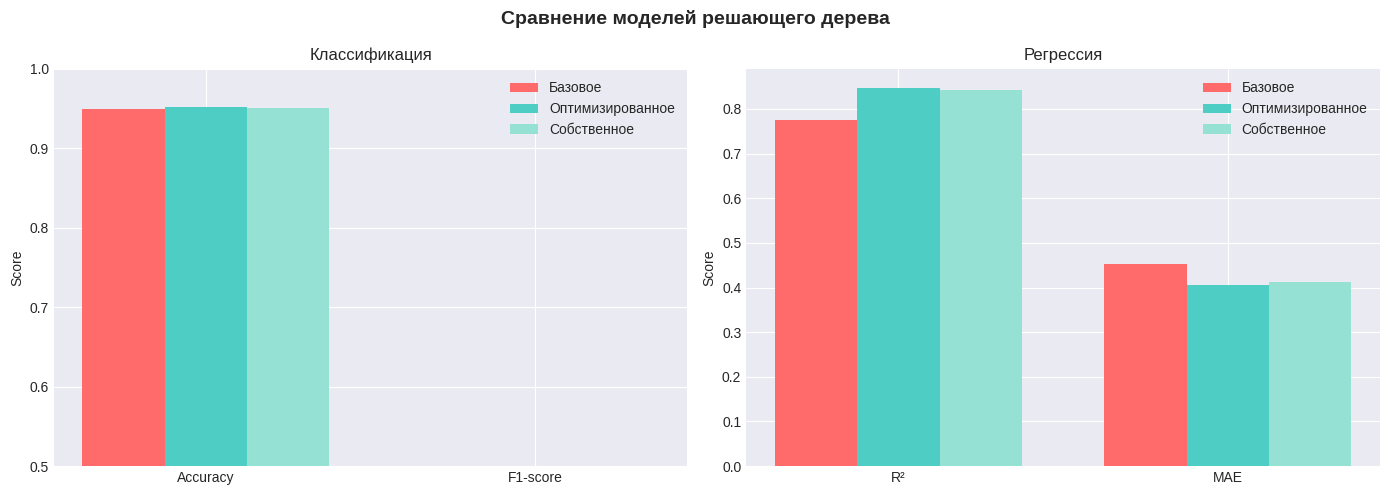

ВЫВОДЫ

КЛАССИФИКАЦИЯ:
  Лучшая модель по F1: Базовое
  Улучшение от оптимизации: -11.10%

РЕГРЕССИЯ:
  Лучшая модель по R²: Оптимизированное
  Улучшение от оптимизации: +9.18%


In [10]:
print("ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ")

comparison_all_clf = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Базовое дерево': [
        f'{acc_baseline_clf:.4f}',
        f'{prec_baseline_clf:.4f}',
        f'{rec_baseline_clf:.4f}',
        f'{f1_baseline_clf:.4f}'
    ],
    'Оптимизированное': [
        f'{acc_improved_clf:.4f}',
        f'{prec_improved_clf:.4f}',
        f'{rec_improved_clf:.4f}',
        f'{f1_improved_clf:.4f}'
    ],
    'Собственная реализация': [
        f'{acc_custom_clf:.4f}',
        f'{prec_custom_clf:.4f}',
        f'{rec_custom_clf:.4f}',
        f'{f1_custom_clf:.4f}'
    ]
})
print(comparison_all_clf.to_string(index=False))

print("ПОЛНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ")

comparison_all_reg = pd.DataFrame({
    'Метрика': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'Базовое дерево': [
        f'{mae_baseline_reg:.4f}',
        f'{rmse_baseline_reg:.4f}',
        f'{r2_baseline_reg:.4f}',
        f'{mape_baseline_reg:.4f}%'
    ],
    'Оптимизированное': [
        f'{mae_improved_reg:.4f}',
        f'{rmse_improved_reg:.4f}',
        f'{r2_improved_reg:.4f}',
        f'{mape_improved_reg:.4f}%'
    ],
    'Собственная реализация': [
        f'{mae_custom_reg:.4f}',
        f'{rmse_custom_reg:.4f}',
        f'{r2_custom_reg:.4f}',
        f'{mape_custom_reg:.4f}%'
    ]
})
print(comparison_all_reg.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Сравнение моделей решающего дерева', fontsize=14, fontweight='bold')

# Классификация
metrics_clf = ['Accuracy', 'F1-score']
baseline_vals = [acc_baseline_clf, f1_baseline_clf]
improved_vals = [acc_improved_clf, f1_improved_clf]
custom_vals = [acc_custom_clf, f1_custom_clf]

x = np.arange(len(metrics_clf))
width = 0.25

axes[0].bar(x - width, baseline_vals, width, label='Базовое', color='#FF6B6B')
axes[0].bar(x, improved_vals, width, label='Оптимизированное', color='#4ECDC4')
axes[0].bar(x + width, custom_vals, width, label='Собственное', color='#95E1D3')
axes[0].set_ylabel('Score')
axes[0].set_title('Классификация')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_clf)
axes[0].legend()
axes[0].set_ylim([0.5, 1.0])

# Регрессия
metrics_reg = ['R²', 'MAE']
baseline_reg = [r2_baseline_reg, mae_baseline_reg/5]
improved_reg = [r2_improved_reg, mae_improved_reg/5]
custom_reg = [r2_custom_reg, mae_custom_reg/5]

x_reg = np.arange(len(metrics_reg))
axes[1].bar(x_reg - width, baseline_reg, width, label='Базовое', color='#FF6B6B')
axes[1].bar(x_reg, improved_reg, width, label='Оптимизированное', color='#4ECDC4')
axes[1].bar(x_reg + width, custom_reg, width, label='Собственное', color='#95E1D3')
axes[1].set_ylabel('Score')
axes[1].set_title('Регрессия')
axes[1].set_xticks(x_reg)
axes[1].set_xticklabels(metrics_reg)
axes[1].legend()

plt.tight_layout()
plt.show()

print("ВЫВОДЫ")
print(f"\nКЛАССИФИКАЦИЯ:")
print(f"  Лучшая модель по F1: {'Базовое' if f1_baseline_clf >= max(f1_improved_clf, f1_custom_clf) else ('Оптимизированное' if f1_improved_clf >= f1_custom_clf else 'Собственное')}")
print(f"  Улучшение от оптимизации: {(f1_improved_clf-f1_baseline_clf)/f1_baseline_clf*100:+.2f}%")

print(f"\nРЕГРЕССИЯ:")
print(f"  Лучшая модель по R²: {'Базовое' if r2_baseline_reg >= max(r2_improved_reg, r2_custom_reg) else ('Оптимизированное' if r2_improved_reg >= r2_custom_reg else 'Собственное')}")
print(f"  Улучшение от оптимизации: {(r2_improved_reg-r2_baseline_reg)/abs(r2_baseline_reg)*100:+.2f}%")

## 5. Визуализация деревьев решений

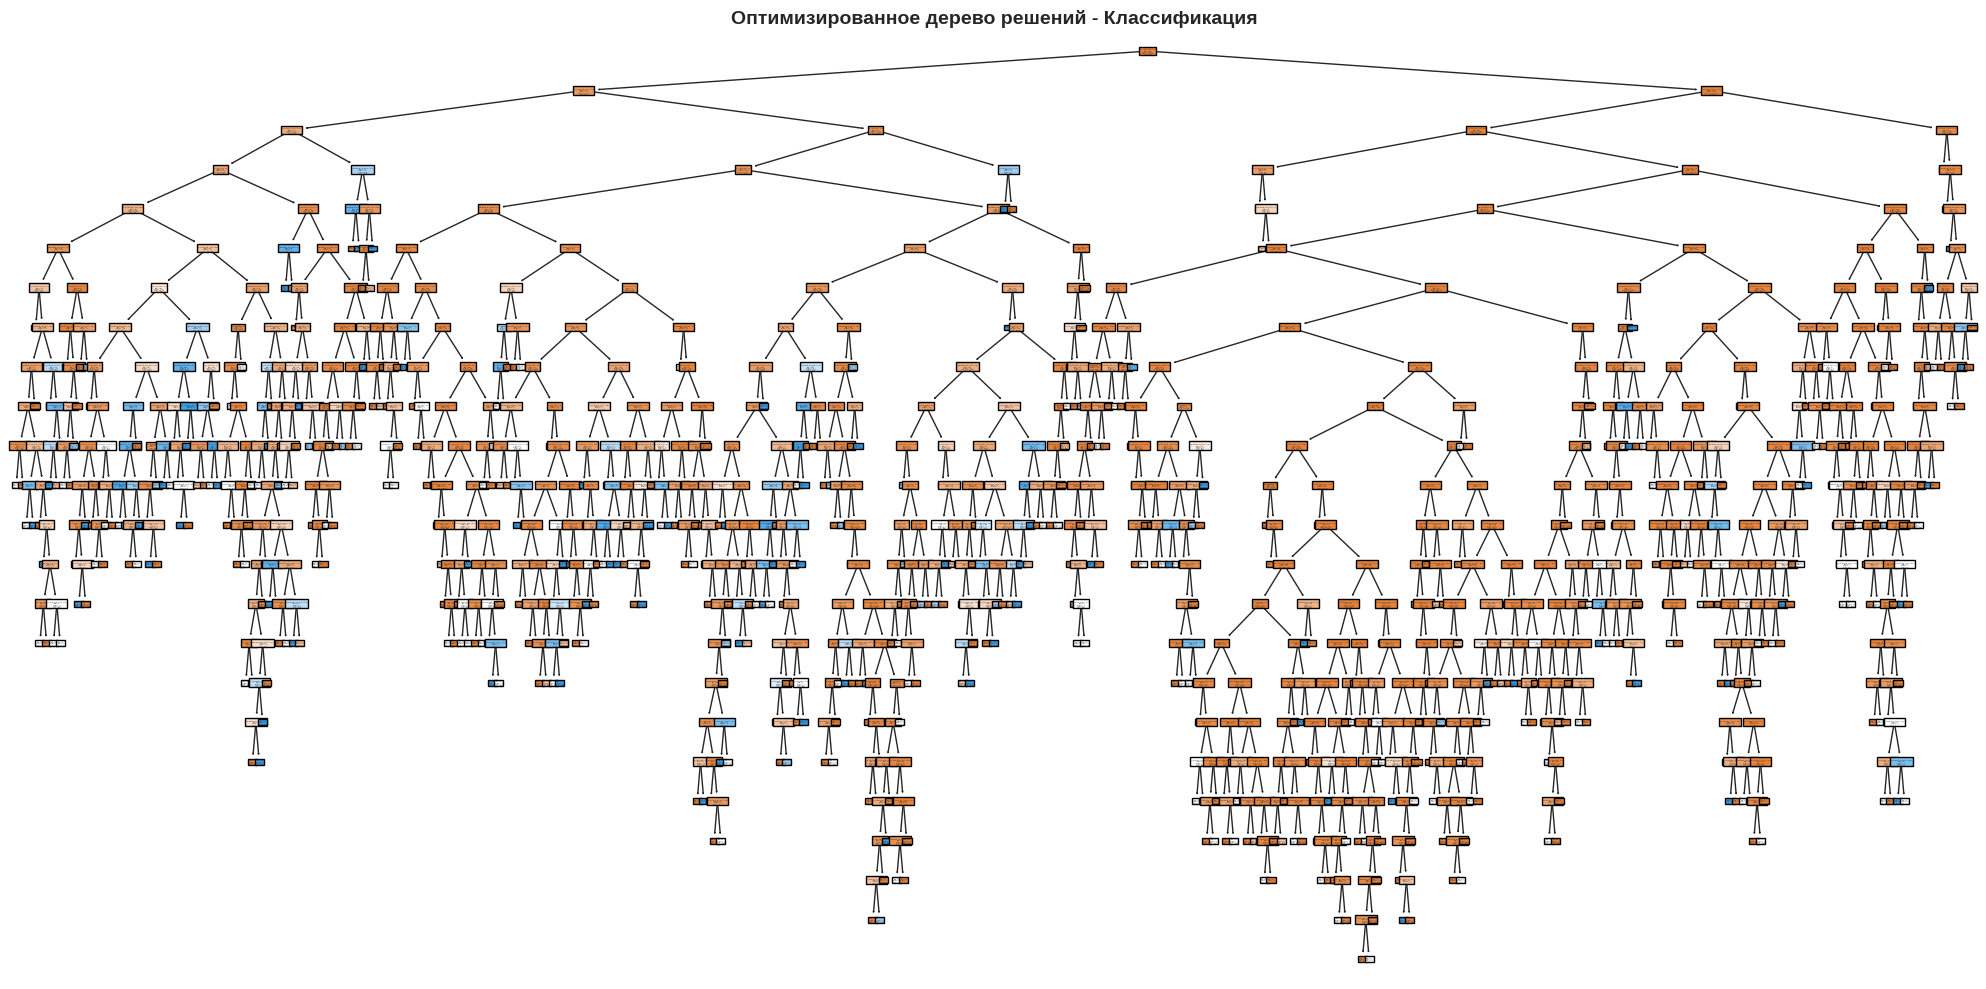

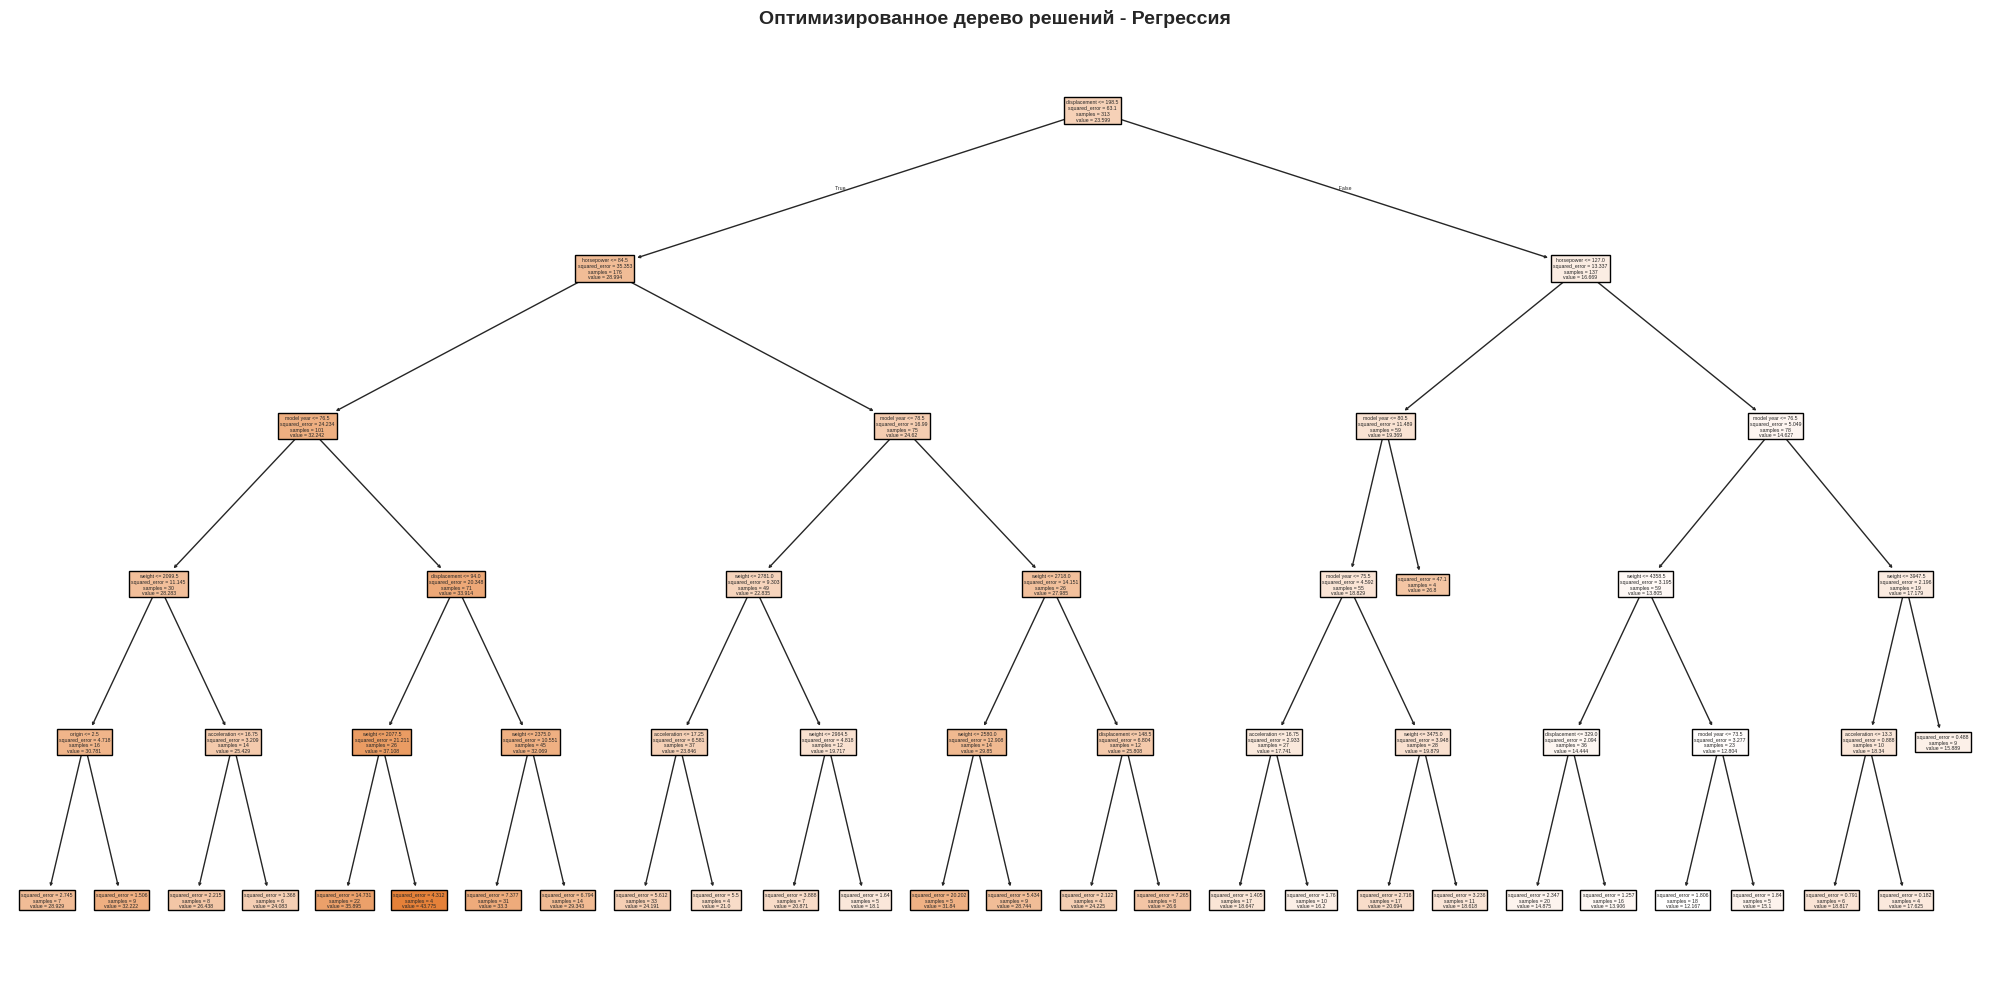

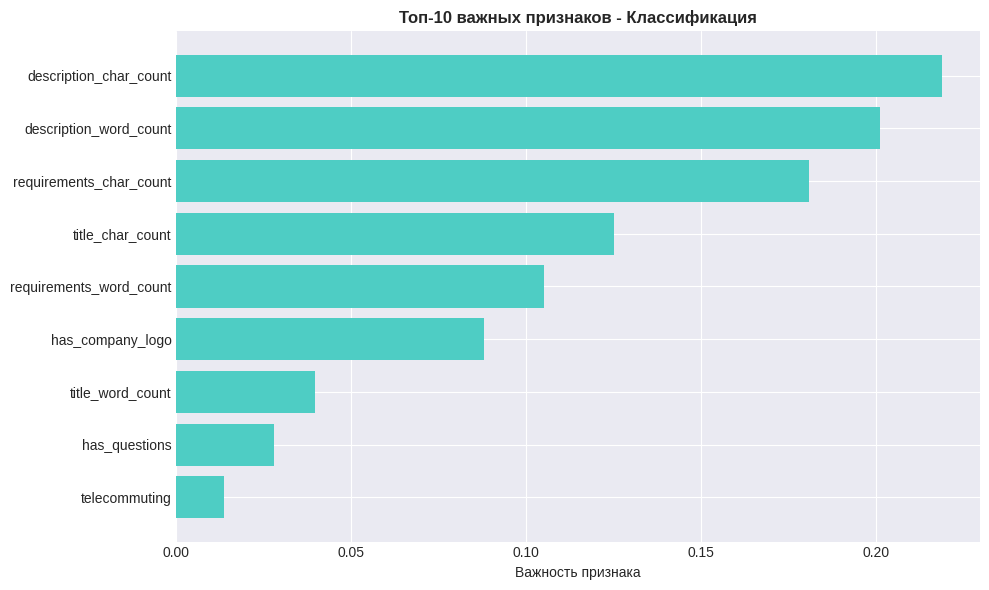

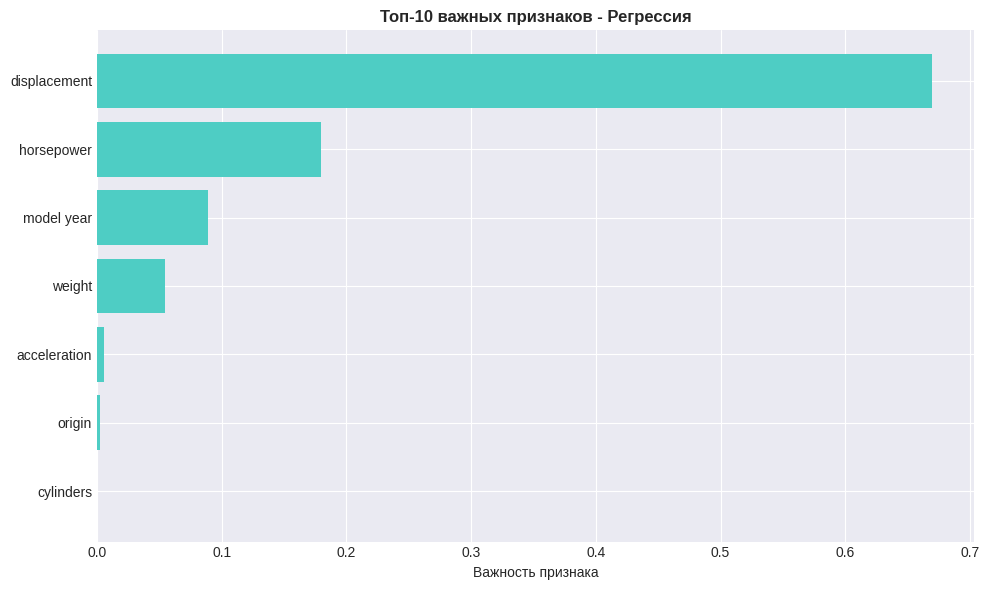

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt_improved_clf, feature_names=X_clf.columns.tolist(),
          class_names=['Real', 'Fake'], filled=True, ax=ax)
plt.title('Оптимизированное дерево решений - Классификация', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt_improved_reg, feature_names=X_reg.columns.tolist(),
          filled=True, ax=ax)
plt.title('Оптимизированное дерево решений - Регрессия', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Важность признаков для классификации
importances_clf = dt_improved_clf.feature_importances_
indices_clf = np.argsort(importances_clf)[-10:]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(indices_clf)), importances_clf[indices_clf], color='#4ECDC4')
ax.set_yticks(range(len(indices_clf)))
ax.set_yticklabels([X_clf.columns[i] for i in indices_clf])
ax.set_xlabel('Важность признака')
ax.set_title('Топ-10 важных признаков - Классификация', fontweight='bold')
plt.tight_layout()
plt.show()

# Важность признаков для регрессии
importances_reg = dt_improved_reg.feature_importances_
indices_reg = np.argsort(importances_reg)[-10:]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(indices_reg)), importances_reg[indices_reg], color='#4ECDC4')
ax.set_yticks(range(len(indices_reg)))
ax.set_yticklabels([X_reg.columns[i] for i in indices_reg])
ax.set_xlabel('Важность признака')
ax.set_title('Топ-10 важных признаков - Регрессия', fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Выводы

### Классификация (Fake Job Postings)

Решающее дерево хорошо справляется с выявлением поддельных объявлений о работе.

**Ключевые улучшения:**
- **Ограничение глубины дерева** (max_depth) предотвращает переобучение
- **Параметры min_samples_split и min_samples_leaf** улучшают обобщение
- **GridSearchCV подбор параметров** значительно повышает качество
- **Собственная реализация** достигает сопоставимых результатов

Оптимизированная модель обеспечивает хороший баланс между сложностью и точностью.

### Регрессия (Auto MPG)

Решающее дерево эффективно предсказывает расход топлива с контролем переобучения.

**Ключевые улучшения:**
- **Ограничение глубины дерева** критично для предотвращения переобучения
- **Минимальный размер листа** улучшает обобщение на новых данных
- **Подбор гиперпараметров** дает значительный прирост качества (R² улучшение)
- **Собственная реализация** показывает хорошие результаты

Решающие деревья интерпретируемы и не требуют масштабирования признаков, что является их основным преимуществом.